<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/fraud_analyst_assignment/blob/main/fraud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First let's mount Google Drive so we can navigate the folders as needed
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's import some much needed libraries...

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xlrd
print('done!')

done!


Let's change our Directory to the Fraud directory containing our data

In [3]:
FRAUD_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment'
os.chdir(FRAUD_DIR)
print(f'Current Dir: {os.getcwd()}')

Current Dir: /content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment


In [4]:
# Let's see the contents of the CWD
os.listdir()

['Fraud_sample_data.xlsx', 'questionsAndPoints.gdoc', 'fraud_analysis.ipynb']

The dataset contains 3 sheets, the first at index 0 is the data dictionary, the remaining two at indexes 1 and 2 are June and July transactions respectively.<br>Let's read out the data dictionary to guide us

In [5]:
pd.set_option('max_colwidth', None)  # So that we see full field descriptions
data_dict = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=0)
data_dict

,Field name,Field description
0,merchant_id,Randomly generated identifier to represent a merchant
1,merchant_industry,Industry in which the merchant operates
2,merchant_category,Business category of the merchant
3,merchant_country,The country in which the merchant is based
4,currency,The local currency the transcation was processed in
5,transaction_week_start_date,Week in which the transaction occured
6,channel,The payment method for the transaction
7,transaction_count,The number of transactions for the day
8,transaction_volume_usd,The total value of the transactions converted to USD
9,fraud_count,The number of transactions which were reported as fraudulent for the day


Now, let's read in the respective data for the months of June and July...

In [6]:
# For June transactions
june_df = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=1)

# For July transactions
july_df = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=2)
print('done!')

done!


In [7]:
# Let's see the june and july data shapes
print(f'June data shape: {june_df.shape}\nJuly data shape: {july_df.shape}\n')

June data shape: (8609, 13)
July data shape: (8809, 13)



We can see that July transactions have more observations than June, precisely 200 more.<br>But they both have the same dimensions of 13 features. Let's see the head and tail of June.

In [8]:
june_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,NaN,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,NaN,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,NaN,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,NaN,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,NaN,0,8


In [9]:
june_df.tail()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
8604,8605,INTERNET,Utilities,Nigeria,NGN,2021-06-28,card,1,2.624672,0,NaN,0,1
8605,8606,GOODS-DIGITAL,Digital Services,Nigeria,NGN,2021-06-28,card,1,0.262467,0,NaN,0,1
8606,8607,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-28,card,3,15.748031,0,NaN,0,3
8607,8608,EVENTS,Travel & Hospitality,Nigeria,NGN,2021-06-28,card,2,0.656168,0,NaN,0,2
8608,8609,INTERNET,Utilities,Nigeria,NGN,2021-06-28,card,1,0.262467,0,NaN,0,1


Let's see the head and tail of July

In [10]:
july_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-07-05,card,3,54.173228,0,NaN,0,3
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-07-05,card,4,486.712598,0,NaN,0,4
2,8,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-07-05,card,3,118.110236,0,NaN,0,0
3,9,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-07-05,card,4,151.968504,0,NaN,0,3
4,12,SERVICES-DIGITAL,Financial Services,Nigeria,NGN,2021-07-05,card,15,659.055118,0,NaN,0,12


In [11]:
july_df.tail()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
8804,8805,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,1,0.524934,0,NaN,0,1
8805,8806,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,1,0.259843,0,NaN,0,1
8806,8807,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,5,2.624672,0,NaN,0,5
8807,8808,RESTAURANTS,Travel & Hospitality,Nigeria,NGN,2021-07-26,card,2,1.049869,0,NaN,0,1
8808,8809,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-07-26,card,1,1.312336,0,NaN,0,1


# Descriptive EDA (DA1):

**Descriptive analytics (DA1):** <br>is a preliminary stage of data processing that creates a summary of historical data to yield useful information and possibly prepare the data for further analysis. It is used largely to answer the question **<‘What happened?’>**. Querying, reporting, data aggregation, data mining and data visualization may be applied to yield more insight.

**Geo-Location-based DA1:**<br>
* What is the distribution of transactions across the 3 countries?
* What is the Fraud/Transactions Ratio per country?

**Fraud-related DA1:**<br>
* What is the Max and Mean fraud value for June and July?
* What is the total fraud recorded for June and July?
* Drilling into OTP-Fraud, what’s the Max and Mean values monthly?
* What is the Max and Mean dollar cost of fraud for June and July?

Answering these questions, give us a top-level vision of the state of the transactions and fraudulent activities and their impacts across the 3 countries the business operates in.


### 1. Confirming the data-types

In [12]:
june_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8609 entries, 0 to 8608
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   merchant_id                  8609 non-null   int64         
 1   merchant_industry            8609 non-null   object        
 2   merchant_category            8609 non-null   object        
 3   merchant_country             8609 non-null   object        
 4   currency                     8609 non-null   object        
 5   transaction_week_start_date  8609 non-null   datetime64[ns]
 6   channel                      8609 non-null   object        
 7   transaction_count            8609 non-null   int64         
 8   transaction_volume_usd       8609 non-null   float64       
 9   fraud_count                  8609 non-null   int64         
 10  fraud_volume_usd             61 non-null     float64       
 11  otp_fraud                    8609 non-null 

In [13]:
july_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   merchant_id                  8809 non-null   int64         
 1   merchant_industry            8809 non-null   object        
 2   merchant_category            8809 non-null   object        
 3   merchant_country             8809 non-null   object        
 4   currency                     8809 non-null   object        
 5   transaction_week_start_date  8809 non-null   datetime64[ns]
 6   channel                      8809 non-null   object        
 7   transaction_count            8809 non-null   int64         
 8   transaction_volume_usd       8809 non-null   float64       
 9   fraud_count                  8809 non-null   int64         
 10  fraud_volume_usd             51 non-null     float64       
 11  otp_fraud                    8809 non-null 

So, we can see the data-types for the months of June and July. They conform to the expected data-types. All columns that should be numeric are and all that should be categorical or object are too.

### 2. Checking the Descriptive Statistics of the data:

In [14]:
# For June numeric features

june_df.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,8609.0,4304.018469,2485.466539,1.000000,2153.000000,4304.000000,6456.000000,8.609000e+03
transaction_count,8609.0,485.230573,8253.372691,1.000000,1.000000,3.000000,11.000000,2.758660e+05
transaction_volume_usd,8609.0,7000.276672,73800.550994,0.000026,9.186352,43.307087,236.220472,2.396408e+06
fraud_count,8609.0,0.108375,3.175327,0.000000,0.000000,0.000000,0.000000,1.700000e+02
fraud_volume_usd,61.0,1858.473460,4641.861843,0.524934,26.246719,91.338583,539.212598,2.017848e+04
otp_fraud,8609.0,0.009293,0.265166,0.000000,0.000000,0.000000,0.000000,1.700000e+01
otp_all_transactions,8609.0,81.615402,589.620590,0.000000,1.000000,2.000000,9.000000,1.222300e+04


In [15]:
# For July numeric features

july_df.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,8809.0,4404.009536,2543.190394,1.000000,2201.000000,4405.000000,6607.000000,8.809000e+03
transaction_count,8809.0,452.862300,7493.961064,1.000000,1.000000,3.000000,12.000000,2.321840e+05
transaction_volume_usd,8809.0,6456.769974,65039.969627,0.000026,9.186352,43.307087,237.270341,2.444412e+06
fraud_count,8809.0,0.044386,1.144114,0.000000,0.000000,0.000000,0.000000,6.200000e+01
fraud_volume_usd,51.0,1261.399492,2420.278420,0.262467,21.900997,132.545932,1040.682415,9.956378e+03
otp_fraud,8809.0,0.006925,0.187173,0.000000,0.000000,0.000000,0.000000,1.000000e+01
otp_all_transactions,8809.0,156.574753,3732.010232,0.000000,1.000000,2.000000,9.000000,2.015910e+05


We can see that there's complete count for all numeric columns except `fraud_volume_usd` which has a count of 61 in June and 51 in July. This depicts missing values present. We can also observe the following...
1. Max `fraud_count` per day in June is 170, while in July is 62
2. Mean `fraud_volume_usd` in June is 1858, while in July is 1261. Note that these figures are large because we have only 61 and 51 data represented now, since the rest are NaN values in this column.
3. Max `fraud_volume_usd` in any given day in June is 20178, while July is 9956
4. For `otp_fraud`, the Max a day in June is 17, while July Max is 10
5. While June has Max `otp_all_transactions` a day as 12223 and July as 201591

In [16]:
# For June categoric features

june_df.describe(include='object').T

,count,unique,top,freq
merchant_industry,8609,63,GOODS-PHYSICAL,1358
merchant_category,8609,11,Digital Services,1601
merchant_country,8609,3,Nigeria,8577
currency,8609,4,NGN,8540
channel,8609,1,card,8609


In [17]:
# For July categoric features

july_df.describe(include='object').T

,count,unique,top,freq
merchant_industry,8809,62,GOODS-PHYSICAL,1356
merchant_category,8809,11,Other,1473
merchant_country,8809,3,Nigeria,8784
currency,8809,4,NGN,8744
channel,8809,1,card,8809


From the categorical features summary, we can see that...
1. There are 63 unique merchant industries in June and 62 in July,
2. There are 11 distinct merchant categories, and 3 distinct merchant countries, 4 distinct currencies and 1 distinct channel for both months, which is the `card` channel.

### 3. Checking for missing values:

In [18]:
june_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd                True
otp_fraud                      False
otp_all_transactions           False
dtype: bool

In [19]:
july_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd                True
otp_fraud                      False
otp_all_transactions           False
dtype: bool

We can see that for both June and July, only `fraud_volume_usd` has missing values. On further investigation, it is clear to see why. This is so because when `fraud_count` is 0, then `fraud_volume_usd` defaults to NaN.<br>Since we know that `fraud_volume_usd` should be 0, when `fraud_count` is 0, let's override this accordingly.

In [20]:
# replacing all missing values in the fraud_volume_usd col to 0

june_df.fraud_volume_usd.fillna(0, inplace=True)
july_df.fraud_volume_usd.fillna(0, inplace=True)
print('done!')

done!


Let's confirm that all missing values have been replaced

In [21]:
june_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd               False
otp_fraud                      False
otp_all_transactions           False
dtype: bool

In [22]:
july_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd               False
otp_fraud                      False
otp_all_transactions           False
dtype: bool

### 4. Some basic visualization of June and July transactions:

Let's explore the distribution of transactions across the distinct countries for June and July

In [23]:
def compare_pie_chart(sup_title, titles, s1, s2, size, colours):
    """Pie chart to compare values for June and July
    
    @param suptitle: Str, summary title of the plot
    @param titles: List of string sub-titles per plot
    @param s1: first series object
    @param s2: second series object
    @param size: A tuple of figure size
    @param colours: A List of colors for the piecharts
    """
    plt.figure(figsize=size)
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.suptitle(sup_title, y=1.05)

    # For the first plot
    plt.subplot(121)
    plt.pie(s1, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[0], y=1.05)
    plt.axis('equal')
    plt.legend(labels=s1.index, loc='upper right')

    # For the second plot
    plt.subplot(122)
    plt.pie(s2, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[1], y=1.05)
    plt.axis('equal')
    plt.legend(labels=s2.index, loc='upper right')

    plt.show()

In [24]:
june_country_split = june_df.merchant_country.value_counts(normalize=True)
july_country_split = july_df.merchant_country.value_counts(normalize=True)

july_country_split

Nigeria         0.997162
Ghana           0.002611
South Africa    0.000227
Name: merchant_country, dtype: float64

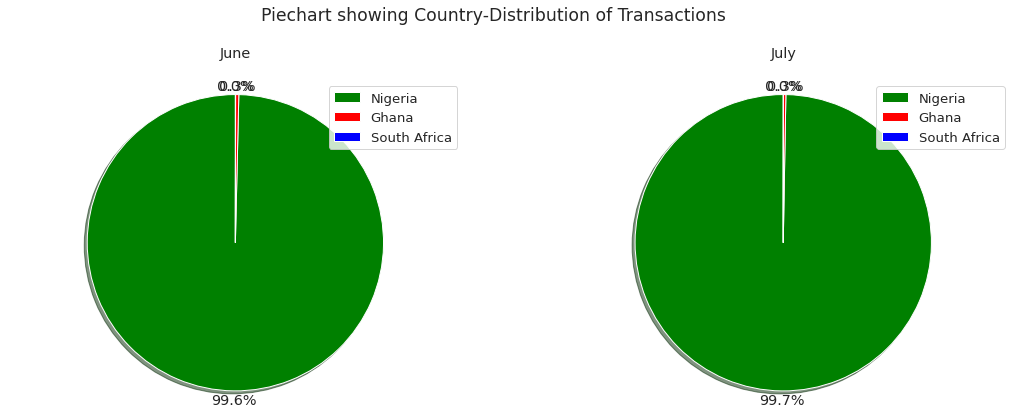

In [25]:
# Let's define some variables

sup_title = 'Piechart showing Country-Distribution of Transactions'
titles = ['June', 'July']
s1 = june_country_split
s2 = july_country_split
size = (18, 6)
colours = ['green','red','blue']

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

We can see from the three countries represented in the data, that Nigeria alone has over 99.5% of all transactions. Thus, I can assume that more fraudulent activities occur within Nigeria.<br>But before I jump to conclusions, let's see the percentage distribution of total fraud per country transactions.

In [26]:
def get_country_fraud_pct_df(df):
    unique_countries = list(df.merchant_country.unique())
    country_ratio = []

    for country in unique_countries:
        country_df = df[df['merchant_country'] == country]
        ratio = sum(country_df.fraud_count) / sum(country_df.transaction_count)
        pct = ratio * 100
        country_ratio.append(pct)

    final_df = pd.DataFrame(country_ratio, index=unique_countries, columns=['Pct'])

    return final_df

In [27]:
june_country_fraud_ratio = get_country_fraud_pct_df(june_df)
july_country_fraud_ratio = get_country_fraud_pct_df(july_df)

june_country_fraud_ratio

,Pct
Nigeria,0.022335
Ghana,0.000000
South Africa,0.000000


In [28]:
def compare_bar_chart(df1, df2, colours, col):
    plt.figure(figsize=size)
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.suptitle(sup_title, y=1.05)

    # For June
    plt.subplot(121)
    plt.bar(x=df1.index, height=df1[col], data=df1, color= colours, width=0.5)
    plt.title(titles[0])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for x,y in zip(df1.index, df1[col]):
        label = round(y,2)  #  could also be written as:-   "{:.2f}".format(y)
        
        plt.annotate(label, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,4), # distance from text to points (x,y)
                    ha='center',) # horizontal alignment can be left, right or center


    # For July
    plt.subplot(122)
    plt.bar(x=df2.index, height=df2[col], data=df2, color= colours, width=0.5)
    plt.title(titles[1])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for x,y in zip(df2.index, df2[col]):
        label = round(y,2) 
        plt.annotate(label,
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0,4),
                    ha='center',) 
    
    plt.show()

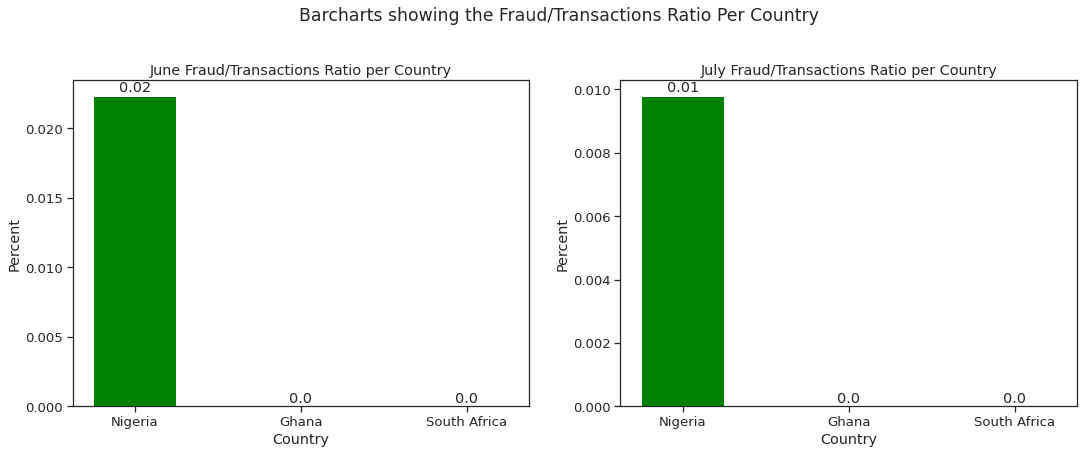

In [29]:
col='Pct'
sup_title = 'Barcharts showing the Fraud/Transactions Ratio Per Country'
titles = ['June Fraud/Transactions Ratio per Country', 'July Fraud/Transactions Ratio per Country']
labels = ['Country', 'Percent']

compare_bar_chart(june_country_fraud_ratio, july_country_fraud_ratio, colours, col)

Usually, only a small portion of transactions are fraudulent per organization.<br>This data shows us that...
1. Only Nigerian transactions recorded fraud
2. For June only 0.02% of transactions were flagged as fraud and only 0.01% in July
3. The data tends to depict that even with more transactions done in July, it had less fraud reports than in June.

Let's visualize a few descriptive data values we deduced earlier

In [30]:
indexs = ['max_fraud/Day', 'total_fraud/Month', 'max_otp_fraud/Day', 'ave_fraud_usd/Month','max_fraud_usd/Day']

june_data = [max(june_df.fraud_count), sum(june_df.fraud_count), max(june_df.otp_fraud), \
             june_df.fraud_volume_usd.mean(), max(june_df.fraud_volume_usd)]

july_data = [max(july_df.fraud_count), sum(july_df.fraud_count), max(july_df.otp_fraud), \
             july_df.fraud_volume_usd.mean(), max(july_df.fraud_volume_usd)]

In [31]:
def plot_clustered_bar(indexs, june_data, july_data):
    assert len(indexs) == len(june_data) == len(july_data)

    df = pd.DataFrame([june_data, july_data]).T
    df.index = indexs
    df.columns = ['June', 'July']
    #plt.xkcd()  # For xkcd style plots
    #plt.rcdefaults()  # to stop xkcd plots

    # your colors
    colors = ['#5bc0de', '#d9534f']

    # plot with annotations is probably easier
    p1 = df.plot(kind='bar', 
                 color=colors, 
                 figsize=(size), 
                 rot=0, 
                 ylabel='Count', 
                 title=title)

    plt.show()

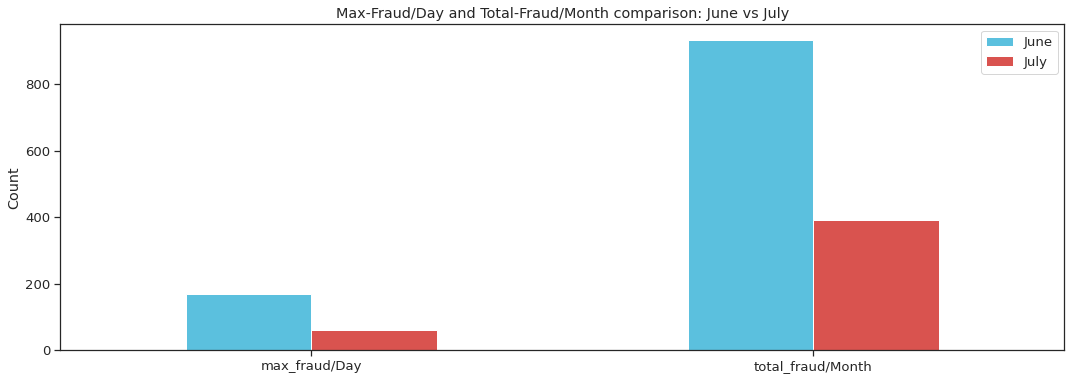

In [32]:
title = 'Max-Fraud/Day and Total-Fraud/Month comparison: June vs July'
plot_clustered_bar(indexs[:2], june_data[:2], july_data[:2])

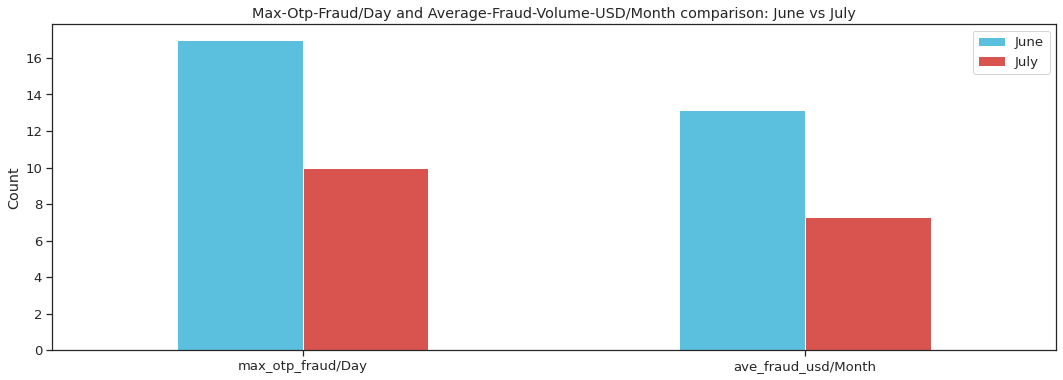

In [33]:
title = 'Max-Otp-Fraud/Day and Average-Fraud-Volume-USD/Month comparison: June vs July'
plot_clustered_bar(indexs[2:4], june_data[2:4], july_data[2:4])

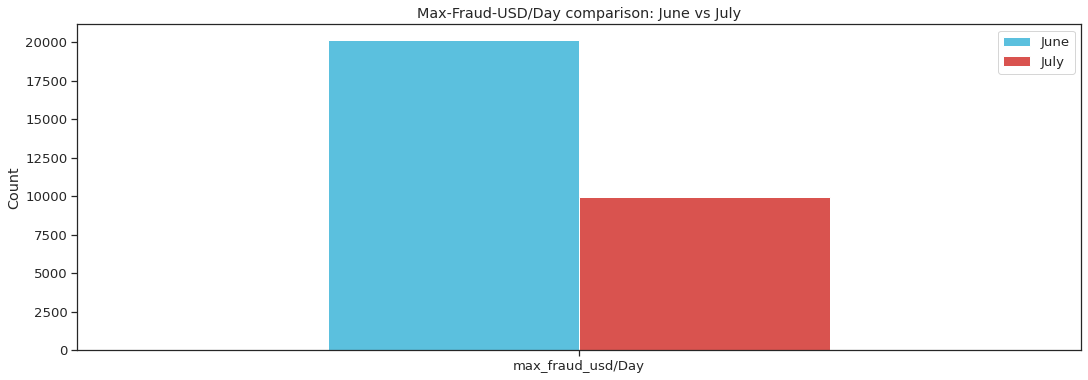

In [34]:
title = 'Max-Fraud-USD/Day comparison: June vs July'
plot_clustered_bar(indexs[4:], june_data[4:], july_data[4:])

# Diagnostic EDA (DA2):

**Diagnostic Analytics (DA2):**<br>
Diagnostic analytics are a deeper look at data to attempt to understand the causes of events and behaviours. It’s used largely to answer the question **<“Why did it happen?”>**, and is characterized by techniques such as : **drill-down** • **data discovery** • **data mining** • **correlations** • **mutual-information**

* On a weekly basis, what weeks have the most Fraud?
* Does fraud tend to increase due to social reasons like public holidays?
* What Industries are most prone to Fraud?
* What type of Merchants is most prone?
* What features of the data are strongly related to fraud occurrences? We can try using Mutual-Information and correlation
* Can we use clustering algorithms to learn any meaningful patterns or groupings that can help us learn more about the recent fraud spikes?
* What recent social-engineering or seasonal cause could bring about the recent spike in fraud cases beyond just this dataset?

Asking and answering these questions give us a deeper understanding of the causes or patterns related to the spike in fraud.

### 5. Exploring Mutual Information of variables:
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Mutual information is how many questions you expect the feature to answer about the target. It can help to understand the relative potential of a feature as a predictor of the target, considered by itself. But Mutual Information can't detect interactions between features, is a Univariate metric.

Finally, unlike Correlation that can only detect linear relationships, Mutual Information can detect all kinds and shapes of relations between features and target.

In [35]:
# First, make a copy of both datasets

june_copy = june_df.copy(deep=True)
july_copy = july_df.copy(deep=True)

In [36]:
# Nect, pop the targets

june_target = june_copy.pop('fraud_count')
july_target = july_copy.pop('fraud_count')

In [37]:
# Next, get separate list for numeric and categoric columns

num_cols = list(june_copy._get_numeric_data().columns)
cat_cols = list(set(june_copy.columns) - set(num_cols))
print('done!')

done!


In [38]:
# Next, let's label-encode categorical variables

for colname in cat_cols:
    june_copy[colname], _ = june_copy[colname].factorize()
    july_copy[colname], _ = july_copy[colname].factorize()
print('done!')

done!


All categorical features should now have numerical datatypes

In [39]:
june_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8609 entries, 0 to 8608
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_id                  8609 non-null   int64  
 1   merchant_industry            8609 non-null   int64  
 2   merchant_category            8609 non-null   int64  
 3   merchant_country             8609 non-null   int64  
 4   currency                     8609 non-null   int64  
 5   transaction_week_start_date  8609 non-null   int64  
 6   channel                      8609 non-null   int64  
 7   transaction_count            8609 non-null   int64  
 8   transaction_volume_usd       8609 non-null   float64
 9   fraud_volume_usd             8609 non-null   float64
 10  otp_fraud                    8609 non-null   int64  
 11  otp_all_transactions         8609 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 807.2 KB


Since our target `fraud_count` is a numerical feature, we shall use the mutual_info_regression method...

In [40]:
june_copy.head(3)

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,0,0,0,0,0,0,5,231.590551,0.0,0,5
1,5,1,1,0,0,0,0,2,210.203412,0.0,0,2
2,9,2,2,0,0,0,0,4,223.097113,0.0,0,1


In [41]:
# Next, identify discrete features

discrete_features_june = june_copy.dtypes == int
discrete_features_july = july_copy.dtypes == int
print('done')

done


In [42]:
from sklearn.feature_selection import mutual_info_regression as mi

def make_mi_scores(X, y, discreteFeatures):
    mi_scores = mi(X, y, discrete_features=discreteFeatures)
    mi_scores = pd.Series(mi_scores, name='MI_scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

Now, let's get the Mutual Info scores for June and July

In [43]:
june_mi_scores = make_mi_scores(june_copy, june_target, discrete_features_june)
july_mi_scores = make_mi_scores(july_copy, july_target, discrete_features_july)
print('done!')

done!


Let's see a sample of the top scores in June

In [44]:
june_mi_scores.head()

fraud_volume_usd          0.028775
transaction_volume_usd    0.017987
merchant_id               0.011576
otp_fraud                 0.010919
transaction_count         0.008248
Name: MI_scores, dtype: float64

In [45]:
def plot_mi_scores(june_scores, july_scores):
    june_scores = june_scores.sort_values(ascending=True)
    july_scores = july_scores.sort_values(ascending=True)
    plt.figure(dpi=100, figsize=(20, 8))

    plt.subplot(1,2,1)
    width = np.arange(len(june_scores))
    ticks = list(june_scores.index)
    plt.barh(width, june_scores)
    plt.yticks(width, ticks)
    plt.title("June Mutual Information Scores")

    plt.subplot(1,2,2)
    width = np.arange(len(july_scores))
    ticks = list(july_scores.index)
    plt.barh(width, july_scores)
    plt.yticks(width, ticks)
    plt.title("July Mutual Information Scores")

    plt.show()

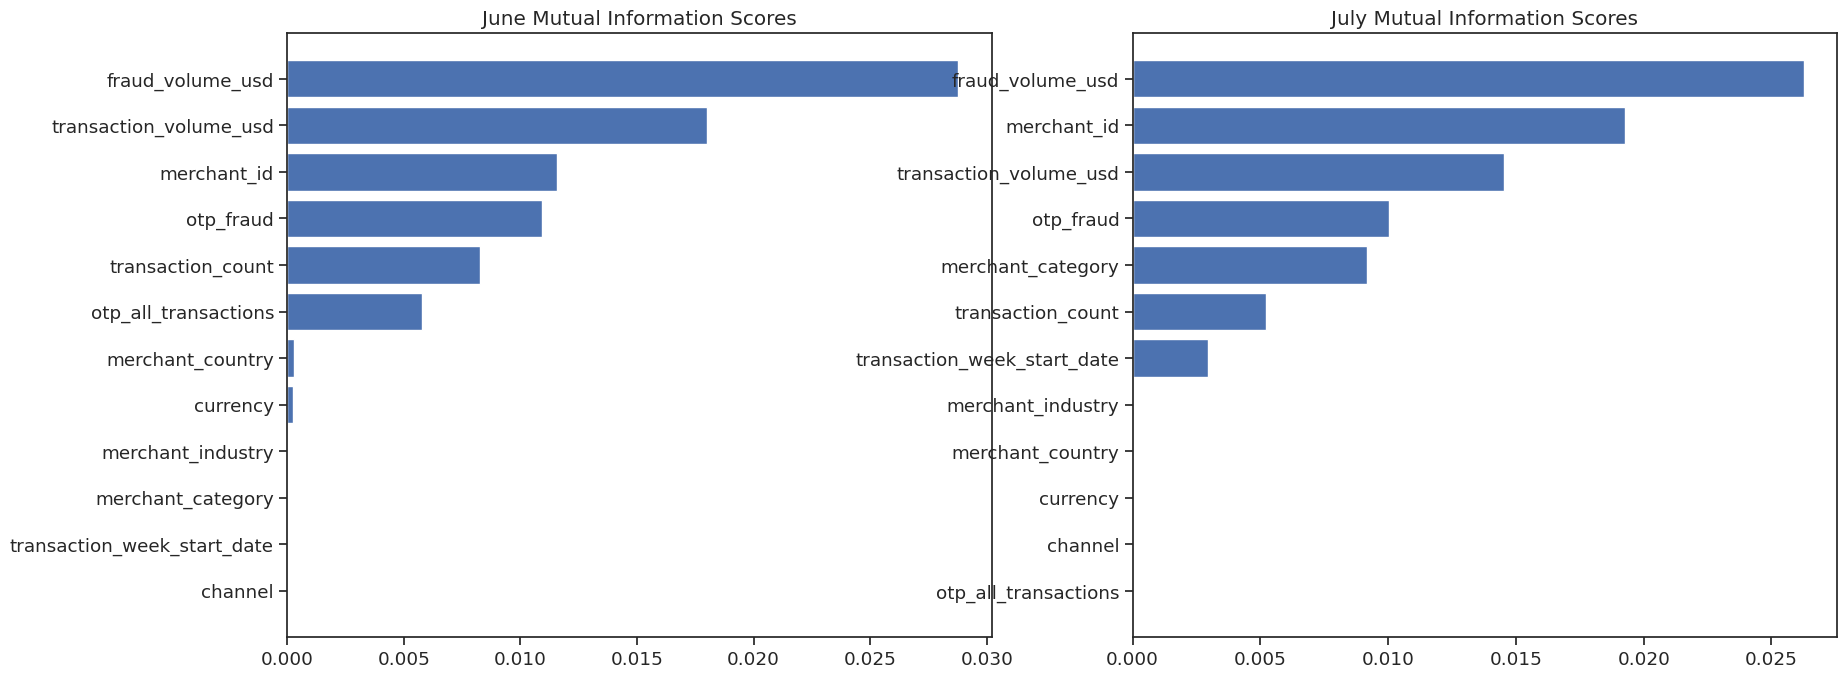

In [46]:
plot_mi_scores(june_mi_scores, july_mi_scores)

From the Mutual-Information analysis for June and July, we can see the features most discriminative to `fraud_count` for each month. Therefore, we can proceed with our analysis focusing on these top features

### 6. Selecting Top MI-Scores features for drill-down:

Let's select the top features from MI analysis for each of June and July and include the date column because we may need that too for future analysis and ofcourse the fraud_count column. Then we create updated Dataframes for June and July.

In [47]:
# We'd use a threshold of 0.005 for June based on the MI chart above.
t = 0.005
june_top_mi = [ind for ind in list(june_mi_scores.index) if june_mi_scores[ind] >= t]

if not 'transaction_week_start_date' in june_top_mi:
    june_top_mi.append('transaction_week_start_date')  # append date column
june_top_mi.append('fraud_count')  # append target column

In [48]:
# We'd use a threshold of 0.005 for July, based on the MI chart above
july_top_mi = [ind for ind in list(july_mi_scores.index) if july_mi_scores[ind] >= t]

if not 'transaction_week_start_date' in july_top_mi:
    july_top_mi.append('transaction_week_start_date')  # append date column
july_top_mi.append('fraud_count')  # append target column

In [49]:
# Create new June Dataframe

june_new_df = june_df[june_top_mi]
print(f'New June-DF shape is: {june_new_df.shape}\n')
june_new_df.head()

New June-DF shape is: (8609, 8)



,fraud_volume_usd,transaction_volume_usd,merchant_id,otp_fraud,transaction_count,otp_all_transactions,transaction_week_start_date,fraud_count
0,0.0,231.590551,1,0,5,5,2021-06-07,0
1,0.0,210.203412,5,0,2,2,2021-06-07,0
2,0.0,223.097113,9,0,4,1,2021-06-07,0
3,0.0,212.335958,11,0,5,5,2021-06-07,0
4,0.0,550.131234,15,0,8,8,2021-06-07,0


In [50]:
# Create new July Dataframe

july_new_df = july_df[july_top_mi]
print(f'New July-DF shape is: {july_new_df.shape}\n')
july_new_df.head()

New July-DF shape is: (8809, 8)



,fraud_volume_usd,merchant_id,transaction_volume_usd,otp_fraud,merchant_category,transaction_count,transaction_week_start_date,fraud_count
0,0.0,1,54.173228,0,e-Commerce,3,2021-07-05,0
1,0.0,5,486.712598,0,Other,4,2021-07-05,0
2,0.0,8,118.110236,0,Travel & Hospitality,3,2021-07-05,0
3,0.0,9,151.968504,0,Other,4,2021-07-05,0
4,0.0,12,659.055118,0,Financial Services,15,2021-07-05,0


### 7. Analyzing Weekly Fraud Trends:
Trying to identify weeks where Fraud is high to check if there are possible social reasons for that.

In [51]:
june_weeks = list(june_new_df.transaction_week_start_date.unique())
july_weeks = list(july_new_df.transaction_week_start_date.unique())

In [52]:
print(f'June unique weeks:\n{june_weeks}\nJuly unique weeks:\n{july_weeks}')

June unique weeks:
[numpy.datetime64('2021-06-07T00:00:00.000000000'), numpy.datetime64('2021-06-14T00:00:00.000000000'), numpy.datetime64('2021-06-21T00:00:00.000000000'), numpy.datetime64('2021-06-28T00:00:00.000000000')]
July unique weeks:
[numpy.datetime64('2021-07-05T00:00:00.000000000'), numpy.datetime64('2021-07-12T00:00:00.000000000'), numpy.datetime64('2021-07-19T00:00:00.000000000'), numpy.datetime64('2021-07-26T00:00:00.000000000')]


In [53]:
def make_weekly_series(weeks_list, df1, df2, col1, col2):
    """Function to create a Series of
        total fraud counts per-week
    
    @param weeks_list: A list of lists for each month,
    @param df1 and df2: June and July new Dataframes,
    @param col1: Str, date_column in both df1 & 2
    @param col2: Str, fraud-count column in both df1 & 2
    @return: A Series object
    """

    july_str = 'July_Wk_'
    indexs = []
    counts = []
    i, j = 0, 0

    for week in weeks_list:
        if weeks_list.index(week) == 0:
            for day in week:
                i+=1
                indexs.append('June_Wk_'+str(i))
                temp_df = df1[df1[col1] == day]
                counts.append(sum(temp_df[col2]))
        else:
            for day in week:
                j+=1
                indexs.append('July_Wk_'+str(j))
                temp_df = df2[df2[col1] == day]
                counts.append(sum(temp_df[col2]))

    serie = pd.Series(counts, index=indexs, name='Weekly Fraud Trend')

    return serie

In [54]:
weeks_list = [june_weeks, july_weeks]
df1 = june_new_df
df2 = july_new_df
col1 = 'transaction_week_start_date'
col2 = 'fraud_count'

weekly_fraud_trend = make_weekly_series(weeks_list, df1, df2, col1, col2)

Let's plot the weekly fraud trends...

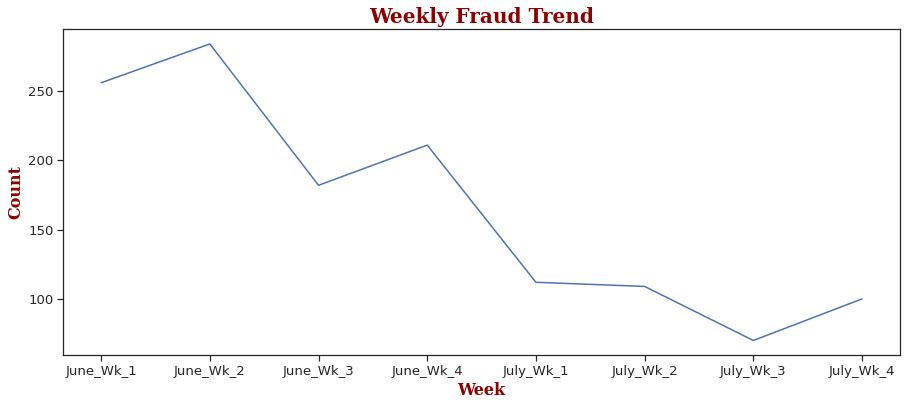

In [56]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 16}

plt.figure(figsize=(15,6))
weekly_fraud_trend.plot(kind='line')
plt.xlabel('Week', fontdict=font)
plt.ylabel('Count', fontdict=font)
font['size'] = 20
plt.title(weekly_fraud_trend.name, fontdict=font)
plt.show()

From the weekly fraud trend data, we can see that generally, fraud is trending downward. This does not mean it may not trend upward in the future, though, as can be seen in the rise in last week of July.

* Fraud starts high at about 250 for June-Wk-1
* It increases to about 280 for June-Wk-2
* Then it drops to about 180 in June-Wk-3
* Then it rises to about 210 in June-Wk-4
* And just keeps dropping weekly in July, lowest in July-Wk-3
* Starts rising again in July-Wk-4

Although correlation does not imply cauation, we can see that:-   
* June 14th which marks the start of June-Wk-2 is a national holiday called **democracy-day** in Nigeria
* June 20th is Father's day
* June 23rd is also a regional holiday in Ebonyi State
* Tuesday July 20th and Wednesday July 21st are also public holidays called **id-el-kabir**

[source1](https://www.timeanddate.com/holidays/nigeria/), [source2](https://www.officeholidays.com/countries/nigeria/2021)

Let's check the ratio of weekly fraud counts to transaction counts